In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
import sys
import math
import random

from skimage.io import imread
from skimage.io import imshow
import skimage.transform as trans

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import roc_auc_score, confusion_matrix, classification_report
from sklearn.linear_model import LogisticRegressionCV
from sklearn.svm import LinearSVC
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA

import pickle as pkl

In [15]:
input_path = 'Alzheimer_s Dataset/'
dataset1 = 'Dataset1/train'
dataset2 = 'Dataset2/'

categories = ['NonDemented', 'VeryMildDemented', 'MildDemented', 'ModerateDemented'] #our labels manually set
#or os.listdir(input_path)

#List containing images in its np.array
images = []
images2 = []


#The hard labels of each picture in order
#labels = []
#labels2 = []

#Number of images of each category
numberofimages = []
numberofimages2 = []


Initial setup -- just skip this and use the np.load function

In [14]:
#similar to rmarkdown to get file directories
for category in categories:
    firstPath = os.path.join(input_path, dataset1, category)
    secondPath = os.path.join(input_path, dataset2, category)

    numberofimages.append(len(os.listdir(firstPath)))
    numberofimages2.append(len(os.listdir(secondPath)))

    for file in os.listdir(firstPath):
        image_paths = os.path.join(firstPath, file) #image in this case refers to title of the image
        image = imread(image_paths, as_gray=True) #reads an image, imread - image + read and grayscales all images
        images.append(image)
        #labels.append(category)

    for file in os.listdir(secondPath):
        image_paths2 = os.path.join(secondPath, file) #image in this case refers to title of the image
        image2 = imread(image_paths2, as_gray=True) #reads an image, imread - image + read and grayscales all images
        images2.append(image2)
        #labels2.append(category)

AttributeError: 'numpy.ndarray' object has no attribute 'append'

Saving my as npy array so we dont gotta keep reusing the top


#Combining of our datasets into one

In [9]:
nonDemented = images[0:2561] + images2[0:3201]
veryMildDemented = images[2561:4353] + images2[3201:5441]
MildDemented = images[4353:5070] + images2[5441:6337]
ModerateDemented = images[5069:5122] + images2[6337:6401]

lst = [nonDemented, veryMildDemented, MildDemented, ModerateDemented]

ValueError: operands could not be broadcast together with shapes (2561,208,176) (3201,128,128) 

In [11]:
zipped = zip(numberofimages, numberofimages2)
totalNum = [sum(i) for i in zipped]
totalNum

[5760, 4032, 1613, 116]

Test resizing of our images. First two lines are the initial dimensions of an image in dataset1 and dataset2

In [12]:
#dimensions of an image
print(nonDemented[1].shape)
print(images2[1].shape)

###resizing
print(trans.resize(nonDemented[1], (128, 128)).shape)
print(nonDemented[1].shape)# there is no change to the original image after the previous function
#different dimensions so we need to preprocess it to the same size




(208, 176)
(128, 128)
(128, 128)
(208, 176)


Graph and pie chart showing imbalanced classes

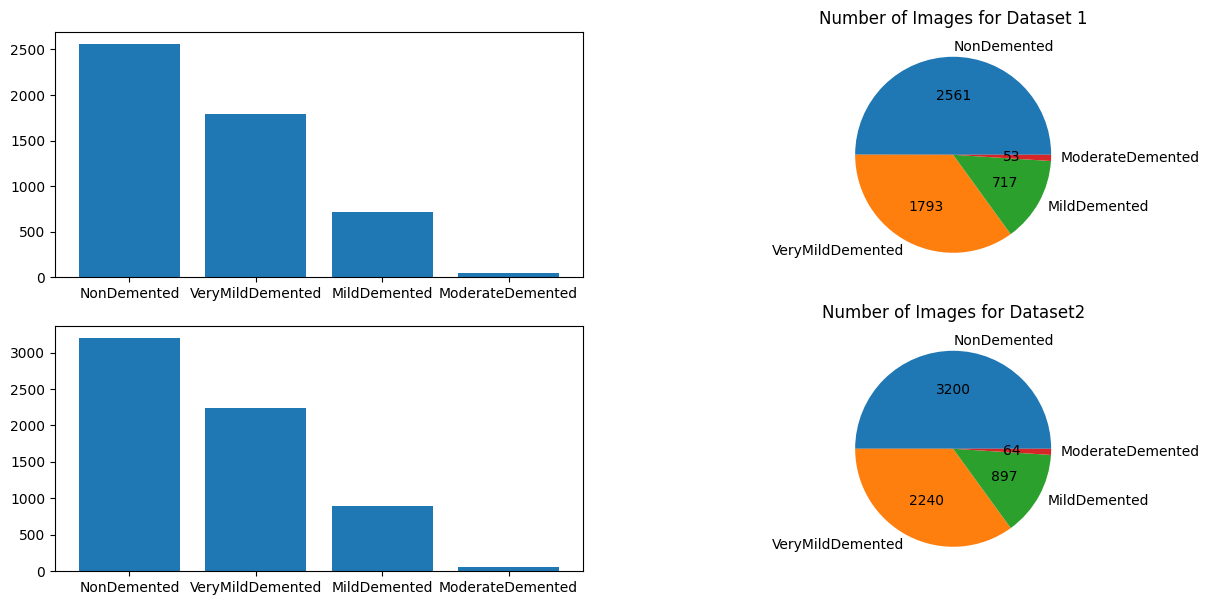

In [13]:
#Plotting number of images for visual representation
fig, ax = plt.subplots(2,2 , figsize = (15,7))
ax[0,0].bar(categories, numberofimages)
ax[0,1].pie(numberofimages, labels= categories, autopct = lambda x: math.ceil(x/100 * sum(numberofimages)))
ax[0,1].set_title('Number of Images for Dataset 1')

ax[1,0].bar(categories, numberofimages2)
ax[1,1].pie(numberofimages2, labels = categories, autopct = lambda x: math.ceil(x/100 * sum(numberofimages2)))
ax[1,1].set_title('Number of Images for Dataset2')

plt.show()

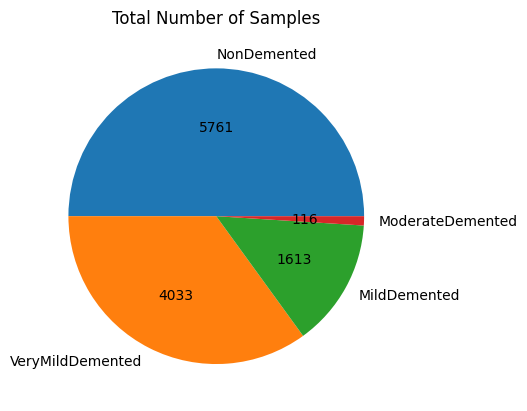

In [14]:
#Overall pie chart
plt.pie(totalNum, labels = categories, autopct = lambda x: math.ceil(x/100 * sum(totalNum)))
plt.title('Total Number of Samples')
plt.show()

Augmentations

In [16]:
#PS I REMOVED SOME LINES CAUSE MY PC CANT HANDLE IT and some small edits
new_ModerateDemented = []
for i in ModerateDemented:
  new_ModerateDemented.append(trans.rotate(i, 15, resize=True))#rotate 30 degrees counter clockwise 
  new_ModerateDemented.append(trans.rotate(i, 345, resize=True))#rotate 30 degrees clockwise   
  #new_ModerateDemented.append(trans.rotate(i, 60, resize=True))#rotate 60 degrees counter clockwise
  #new_ModerateDemented.append(trans.rotate(i, 300, resize=True))#rotate 60 degrees clockwise    
  new_ModerateDemented.append(trans.rotate(i, 5, resize=True))#rotate 5 degrees counterclockwise 
  new_ModerateDemented.append(trans.rotate(i,355, resize=True))#rotate 90 degrees clockwise then resize
  new_ModerateDemented.append(trans.rotate(i, 10, resize=True))#rotate 120 degrees counter clockwise   
  new_ModerateDemented.append(trans.rotate(i, 350, resize=True))#rotate 120 degrees clockwise  
  #new_ModerateDemented.append(trans.rotate(i, 150, resize=True))#rotate 150 degrees counterclockwise 
  #new_ModerateDemented.append(trans.rotate(i,210, resize=True),)#rotate 150 degrees clockwise 
  #new_ModerateDemented.append(trans.rotate(i, 180, resize=True))#flip upside down
  new_ModerateDemented.append(trans.rotate(i[::-1], 180)) #Horizontal rotation
  #labels.extend(np.repeat('ModerateDemented',7))

print(len(new_ModerateDemented))#new data points

ModerateDemented += new_ModerateDemented#added new data into ModerateDemented
numberofimages[3] += len(new_ModerateDemented)#updated numbers for image
print(numberofimages) #Number of new images for dataset 1

805
[2560, 1792, 717, 857]


#Creating labels for each class after augmentation

In [17]:
labels = []
for i in range(len(lst)):
    num = len(lst[i]);
    labels.extend(np.repeat(categories[i],num))

edit below using trans


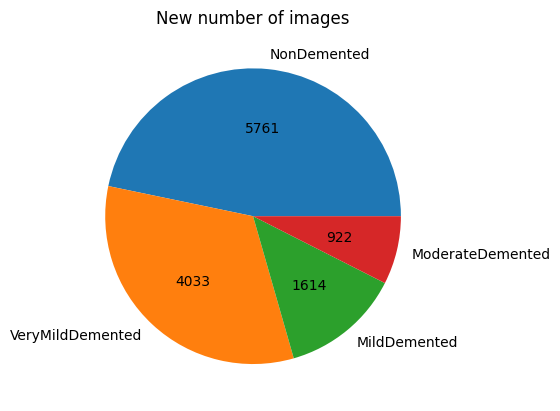

In [18]:
totalNum = [sum(i) for i in zip(numberofimages, numberofimages2)]
plt.pie(totalNum, labels = categories, autopct = lambda x: math.ceil(x/100 * sum(totalNum)))
plt.title('New number of images')
plt.show()

Showing an example of augmentation

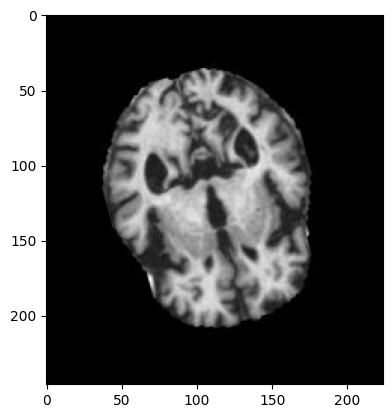

In [19]:
plt.imshow(new_ModerateDemented[0], cmap = 'gray')

#new Augmented images

In [20]:
#resizing all of image into 128X128
trans_nonDemented = []
for i in nonDemented:
    trans_nonDemented.append(trans.resize(i, (128, 128)))

trans_MildDemented = []
for i in MildDemented:
    trans_MildDemented.append(trans.resize(i, (128, 128)))

trans_veryMildDemented = []
for i in veryMildDemented:
    trans_veryMildDemented.append(trans.resize(i, (128, 128)))

trans_ModerateDemented = []
for i in ModerateDemented:
    trans_ModerateDemented.append(trans.resize(i, (128, 128)))

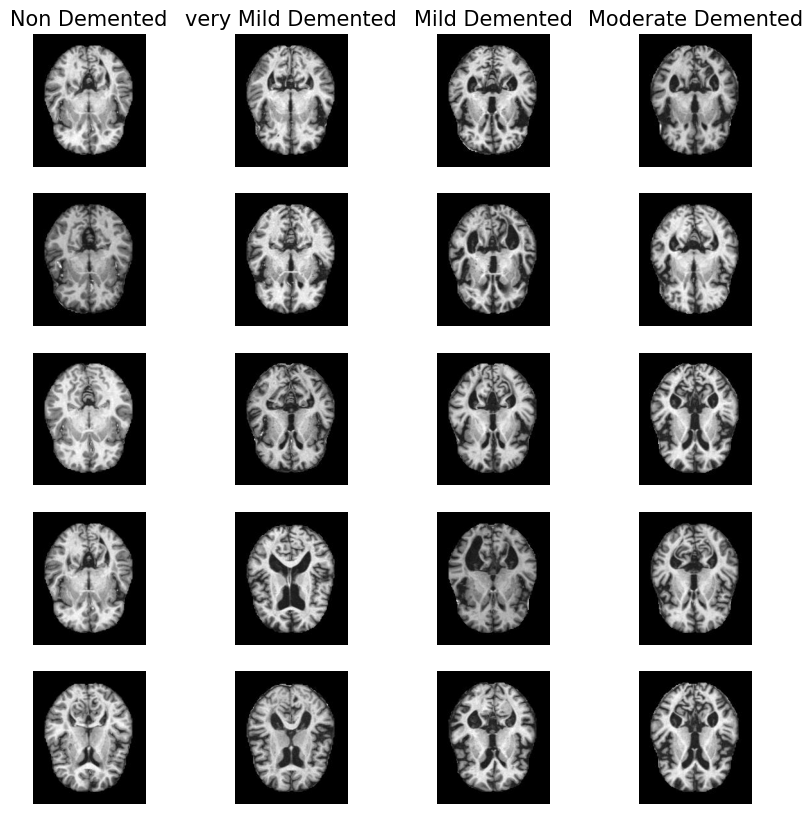

In [14]:
#First 4 pictures to roughly show how each MRI Scan for each category looks like
fig,axes = plt.subplots(5,4, figsize = (10,10))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        axes[j,i].imshow(img, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 15)
axes[0,1].set_title('very Mild Demented', fontsize = 15)
axes[0,2].set_title('Mild Demented', fontsize = 15)
axes[0,3].set_title('Moderate Demented', fontsize = 15)
plt.show()

In [21]:
#Flatten 30 images and join them together then plot a histogram to get the rough distribution of the pixels rgb;
allFlattened = []
for i in range(len(lst)):
    flat = []
    for j in range(30):
        flat.extend(lst[i][j].flatten()) #extend function instead of append to add raw values rather than a list
    allFlattened.append(flat)


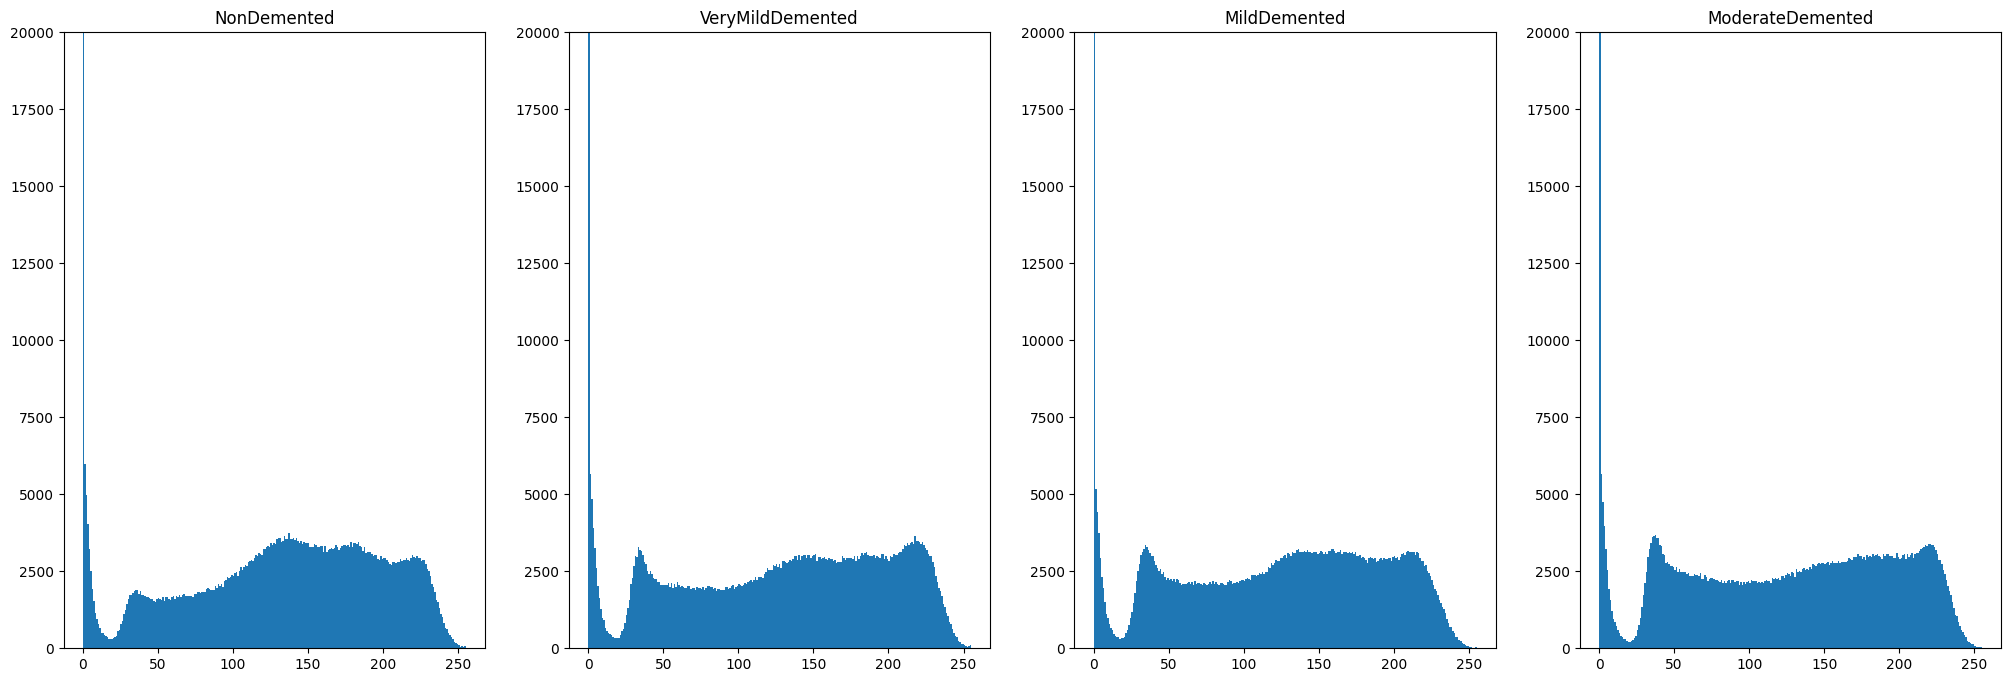

In [22]:
fig, axes = plt.subplots(1,4, figsize = (25,8))
for i in range(len(allFlattened)):
    axes[i].hist(allFlattened[i], bins = 255)
    axes[i].set_title(categories[i])
    #axes[i].set_xlim([20,255])
    axes[i].set_ylim([0,20000])


In the region of pixel color 20-75?, its noticable that the non demented people have significantly less black pixels
Can play around with the bin number but it shows almost the same r/s

But theres not very evident r/s between the pixels and the severity of dementia

Now convert it to binary image by setting pixel 50 to approximately 100 as the region as white and the rest as black and do an image visualization

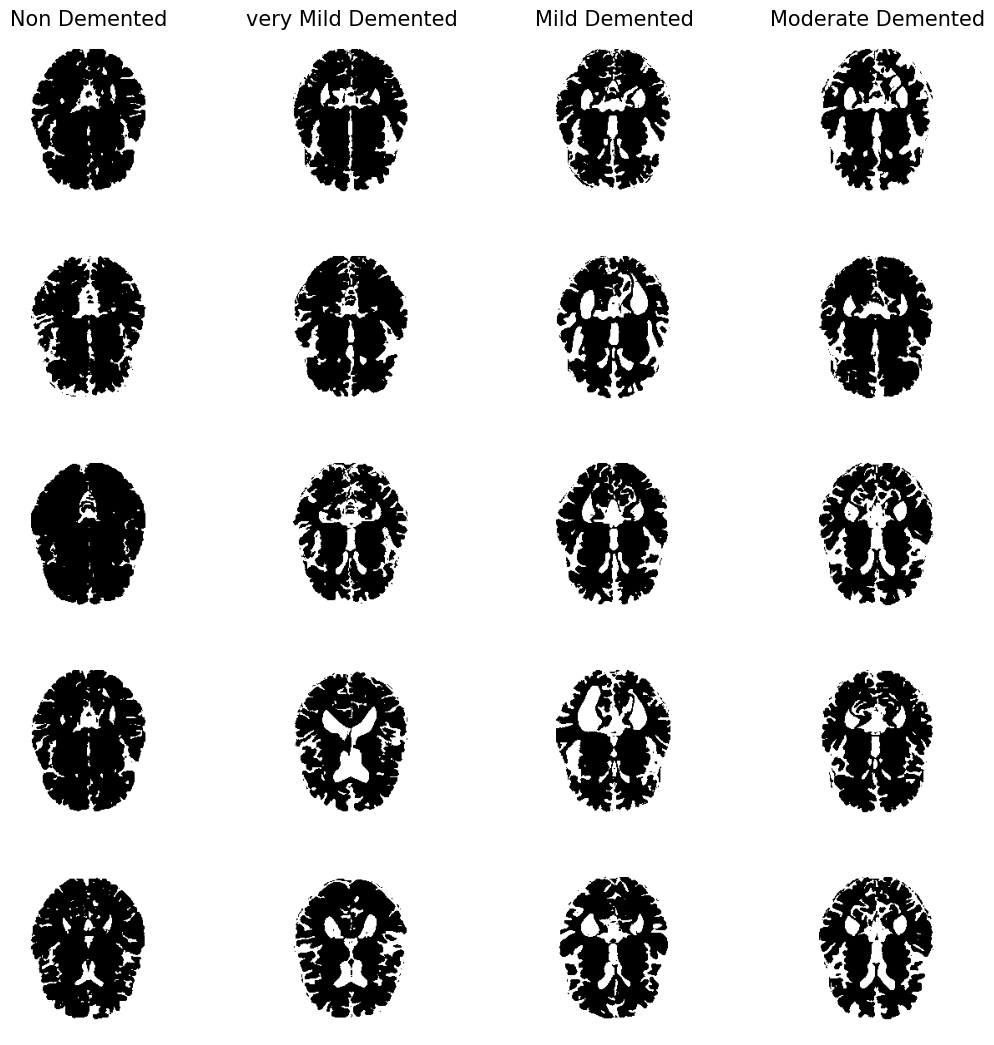

In [30]:
#Convert all pictures to binary to showcase degree of white are
fig,axes = plt.subplots(5,4, figsize = (13,13))

for i in range(len(lst)):
    for j in range(5):
        img = lst[i][j]
        #binary1 = np.where(img >= 50,1,0)
        binary2 = np.where(img <= 90,1,0)
        #newimg = binary1 + binary2
        axes[j,i].imshow(binary2, cmap = 'gray')
        axes[j,i].axis('off') #turn off axis for each subplot
axes[0,0].set_title('Non Demented', fontsize = 15)
axes[0,1].set_title('very Mild Demented', fontsize = 15)
axes[0,2].set_title('Mild Demented', fontsize = 15)
axes[0,3].set_title('Moderate Demented', fontsize = 15)
plt.show()

Convert our dataset to binary image, did opposite of our graph which(like switched the black and white part like the image above instead) 

In [ ]:
newBinaryImages = []
sum = 0
for classes in lst:
    for imgs in classes:
        binary2 = np.where(img <= 90,0,1)
        
        newBinaryImages.append(binary2)
len(newBinaryImages)

12327

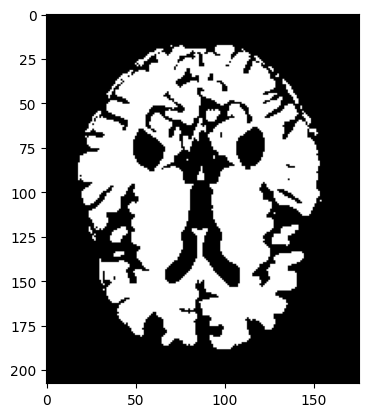

In [32]:
plt.imshow(newBinaryImages[10000], cmap = 'gray')

Appears that the middle region has increasing number of white pixels as well as the sides of the bottom

Seems to have greater atrophy of muscles as alzheimer progress increases

this coincides with the picture in the reference image, hippocamus area has increasing amounts of white pixels(the part that looks like an egg) + muscle walls or something become less thick
but also pretty difficult to differentiate between mild and moderate alzheimer



#reference to image
https://www.mdpi.com/1422-0067/22/4/2110


#########




Making the Machine Learning Models

Joining all class images into one array

In [33]:
len(trans_ModerateDemented)

920

In [34]:
testImages = []
testImages.extend(trans_nonDemented)
testImages.extend(trans_veryMildDemented)
testImages.extend(trans_MildDemented)
testImages.extend(trans_ModerateDemented)


In [36]:
originalImages_file = open('originalIamges_file.pkl', 'wb')
binaryImages_file = open('binaryImages_file.pkl', 'wb')

pkl.dump(newBinaryImages, binaryImages_file)
pkl.dump(testImages, originalImages_file)

KeyboardInterrupt: 

In [21]:
testImages[100].shape

(128, 128)

In [65]:
classificationLabels = np.where(np.array(labels) == 'NonDemented', 0, 1)
classificationLabels

array([0, 0, 0, ..., 1, 1, 1])

In [66]:
X_train, X_test, y_train, y_test = train_test_split(newBinaryImages, classificationLabels, test_size= 0.25, shuffle=True, random_state= 9)

In [44]:
len(X_train)

9245

#Feature engineering, downsampling + normalization of data(because different 'intensity' of each image like some are darker than others)

In [67]:
X_train

[array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]),
 array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
   

In [75]:
len(X_train_flat[0])

36608

In [80]:
X_train_flat = np.reshape(X_train, (9245, -1)) #9245 is the length of X_train
X_test_flat = np.reshape(X_test, (len(X_test),-1))

MemoryError: Unable to allocate 1.26 GiB for an array with shape (9245, 208, 176) and data type int32

imread already converts matrices between [0,1] so dont need to /255

In [53]:
kf = KFold(shuffle = True, random_state = 9)

In [81]:
logreg = LogisticRegressionCV(cv = kf)
logreg.fit(X_train_flat, y_train)



MemoryError: Unable to allocate 2.52 GiB for an array with shape (9245, 36608) and data type float64

In [ ]:
logreg.predict_proba(X_test_flat)

array([[0.17841992, 0.82158008],
       [0.48419482, 0.51580518],
       [0.79097856, 0.20902144],
       ...,
       [0.65189751, 0.34810249],
       [0.03066482, 0.96933518],
       [0.75844654, 0.24155346]])

In [ ]:
logypred = logreg.predict(X_test_flat)
print(classification_report(logypred, y_test))
print(confusion_matrix(logypred,y_test))

              precision    recall  f1-score   support

           0       0.91      0.88      0.90      1408
           1       0.91      0.92      0.91      1674

    accuracy                           0.91      3082
   macro avg       0.91      0.90      0.90      3082
weighted avg       0.91      0.91      0.91      3082

[[1246  162]
 [ 130 1544]]


In [61]:
svm = LinearSVC()
svm.fit(X_train_flat, y_train)

MemoryError: Unable to allocate 2.52 GiB for an array with shape (9245, 36608) and data type float64

In [ ]:
svmypred = svm.predict(X_test_flat)
print(classification_report(svmypred, y_test))
confusion_matrix(svmypred,y_test)

              precision    recall  f1-score   support

           0       0.86      0.85      0.86      1390
           1       0.88      0.89      0.88      1692

    accuracy                           0.87      3082
   macro avg       0.87      0.87      0.87      3082
weighted avg       0.87      0.87      0.87      3082



array([[1187,  203],
       [ 189, 1503]], dtype=int64)